In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
from processing_functions import create_df

df_main = create_df(timeFramesUsedInMinutes=["1"], instrument="ES", 
                    start_date = "2023-03-24 12:00", end_date = "2025-02-14 12:00") 

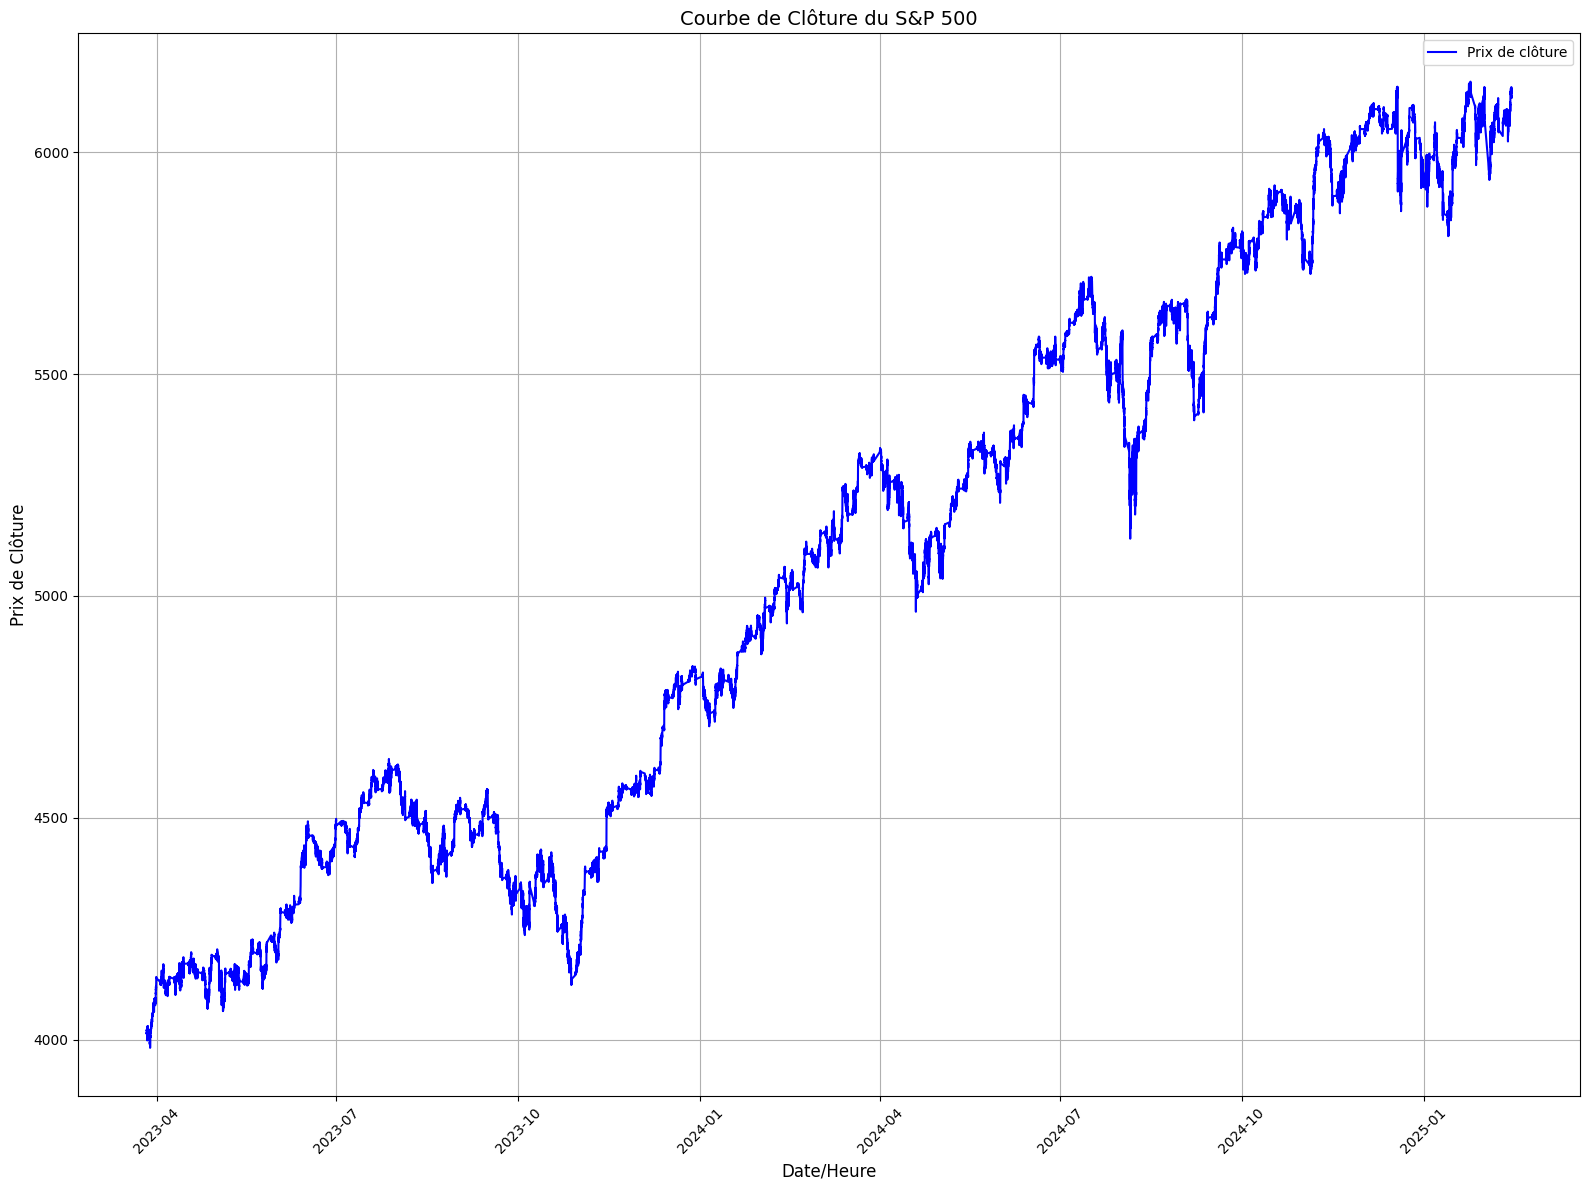

In [ ]:

import matplotlib.pyplot as plt 
plt.figure(figsize=(16,12))
plt.plot(df_main['datetime'], df_main['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

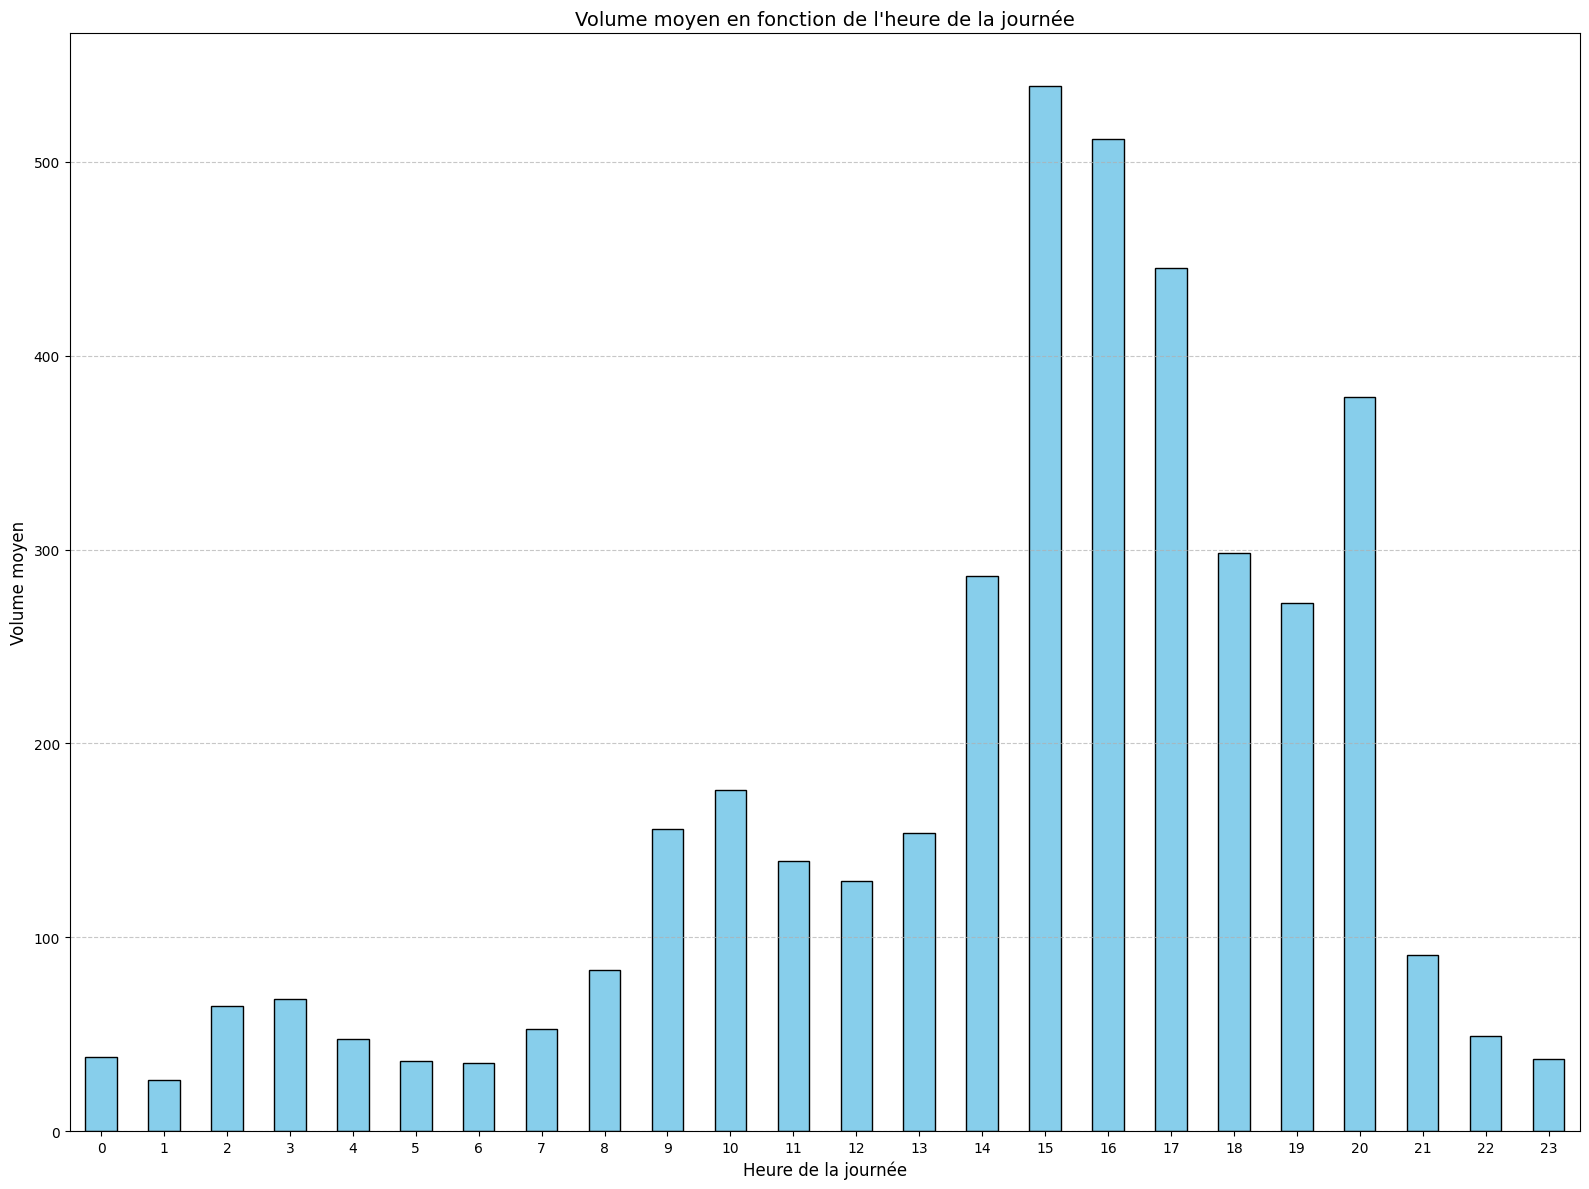

In [3]:

# Extraire l'heure de la journée à partir de 'timestamp'
df_main['hour'] = df_main['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_main.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(16, 12))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

In [ ]:
from processing_functions import return_trade_datas_dataframe

filename="size=1_timeframe=[[5], [5, 15]]_slInTicks=[[50, 70], [15, 40], [25, 50], [40, 50]]_tpInTicks=[[25, 70], [30, 80]]_KijunExitMethod=[1, 3]_forbiddenHours=[[]]_slModifiers=[[], [[0.6, 0.15]], [[0.7, 0.2], [0.5, 0.12]]]"
filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}_real.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
735,50.289,-27.58,-31.51,0.396,-0.447,0.90,"(696, 688, 0)",16.0,17.8,"(15, 25, 40, 70)",0 days 00:15:00,0 days 00:50:00,[5],2,[],[],3,False,0
739,50.467,-24.10,-27.75,0.402,-0.454,0.90,"(648, 636, 0)",16.2,18.0,"(15, 25, 40, 70)",0 days 00:15:00,0 days 00:50:00,[5],2,[],[],3,False,1
723,48.936,-22.58,-26.45,0.424,-0.445,0.97,"(667, 696, 0)",17.1,17.7,"(15, 25, 40, 70)",0 days 00:20:00,0 days 00:52:30,[5],2,[],[],1,False,0
743,50.668,-22.65,-26.05,0.403,-0.458,0.89,"(607, 591, 0)",16.2,18.2,"(15, 25, 40, 70)",0 days 00:15:00,0 days 00:45:00,[5],2,[],[],3,False,2
731,49.579,-21.30,-24.67,0.421,-0.456,0.94,"(589, 599, 0)",17.0,18.1,"(15, 25, 40, 70)",0 days 00:15:00,0 days 00:45:00,[5],2,[],[],1,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,81.316,272.98,269.99,0.628,-1.351,0.26,"(853, 196, 1)",14.2,54.2,"(50, 25, 70, 70)",0 days 00:35:00,0 days 01:35:00,[5],2,"[[0.6, 0.15]]",[],3,False,1
611,81.410,276.82,274.04,0.654,-1.351,0.27,"(797, 182, 1)",14.6,54.2,"(50, 25, 70, 70)",0 days 00:35:00,0 days 01:35:00,[5],2,"[[0.6, 0.15]]",[],1,False,2
615,80.780,282.58,279.44,0.634,-1.341,0.26,"(891, 212, 1)",14.0,53.8,"(50, 25, 70, 70)",0 days 00:40:00,0 days 01:40:00,[5],2,"[[0.6, 0.15]]",[],3,False,0
607,81.232,294.62,291.67,0.658,-1.345,0.27,"(844, 195, 1)",14.6,54.0,"(50, 25, 70, 70)",0 days 00:35:00,0 days 01:35:00,[5],2,"[[0.6, 0.15]]",[],1,False,1


In [4]:
from processing_functions import return_trade_datas_dataframe

filename="size=1_timeframe=[[1], [5]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_forbiddenHours=[[]]_slModifiers=[[[0.6, 0.15]]]"
filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}_real.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
6,79.188,58.97,58.41,0.772,-1.408,0.38,"(156, 41, 3)",23.0,60.3,"(50, 25, 70, 70)",0 days 00:45:00,0 days 02:21:15,[5],2,"[[0.6, 0.15]]",[],1,True,1
5,92.073,72.55,65.10,0.158,-1.519,0.10,"(2416, 208, 0)",6.2,60.7,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:14:30,[1],2,"[[0.6, 0.15]]",[],1,True,1
2,78.947,67.18,66.58,0.793,-1.398,0.40,"(165, 44, 2)",23.2,58.4,"(50, 25, 70, 70)",0 days 00:45:00,0 days 02:25:00,[5],2,"[[0.6, 0.15]]",[],1,True,0
1,92.338,83.40,74.73,0.154,-1.536,0.10,"(2820, 234, 0)",6.1,61.3,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:14:57.500000,[1],2,"[[0.6, 0.15]]",[],1,True,0
8,80.143,307.52,304.34,0.660,-1.276,0.28,"(896, 222, 3)",14.7,51.6,"(50, 25, 70, 70)",0 days 00:25:00,0 days 01:25:00,[5],2,"[[0.6, 0.15]]",[],1,False,1
4,79.470,315.12,311.80,0.667,-1.272,0.29,"(929, 240, 2)",14.9,51.2,"(50, 25, 70, 70)",0 days 00:30:00,0 days 01:25:00,[5],2,"[[0.6, 0.15]]",[],1,False,0
7,90.993,408.62,377.73,0.167,-1.302,0.10,"(9900, 980, 0)",5.3,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.6, 0.15]]",[],1,False,1
3,91.112,454.55,417.97,0.163,-1.302,0.10,"(11737, 1145, 0)",5.2,52.0,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:15:30,[1],2,"[[0.6, 0.15]]",[],1,False,0


In [6]:
from processing_functions import get_winrate_by_short_and_long_position
get_winrate_by_short_and_long_position(filepath, 3)

winrate short: 0.9567786594631099, winrate long: 0.8722517603103894


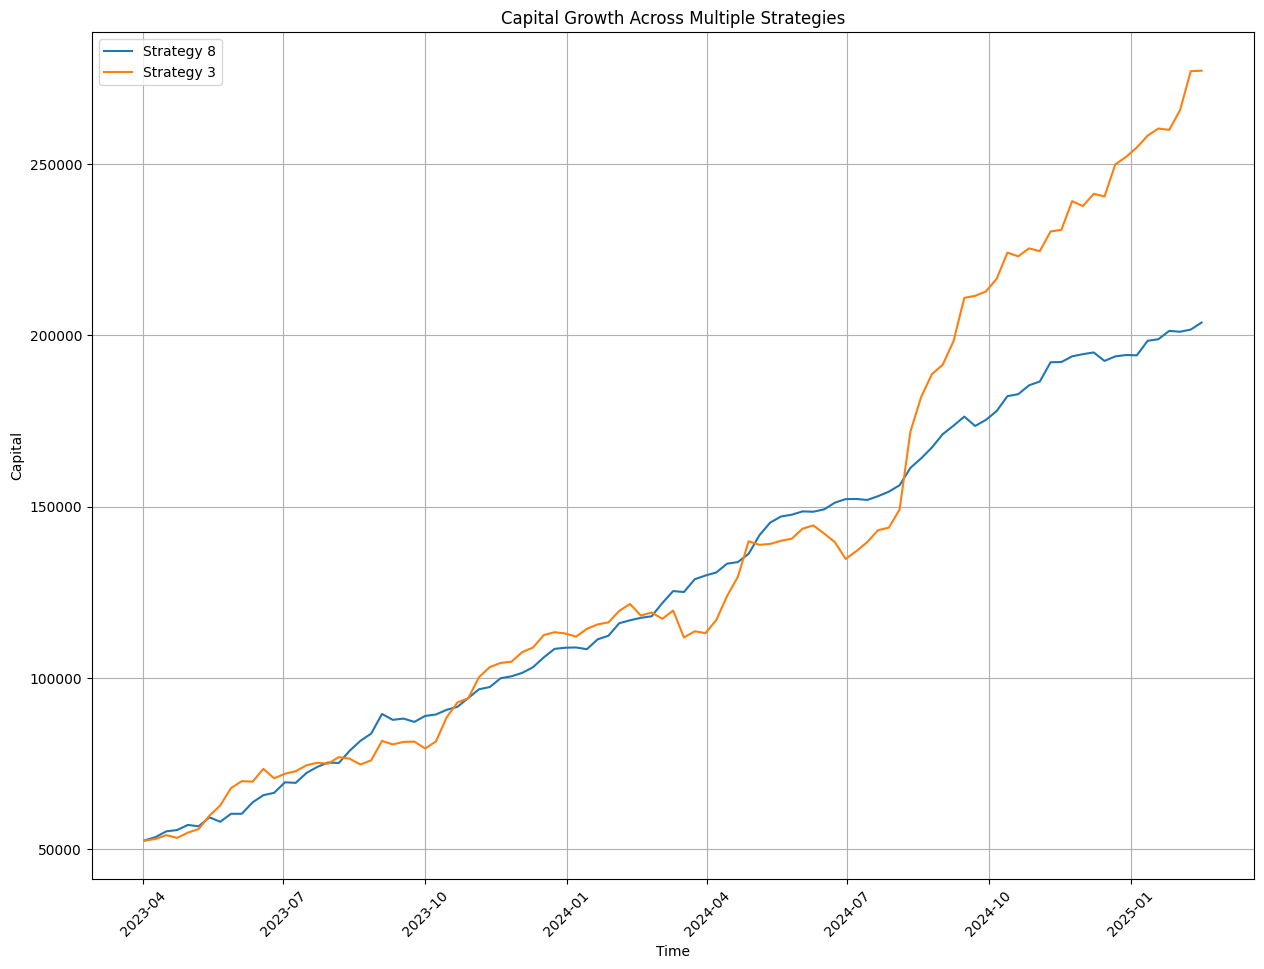

In [8]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[8,3],
                             plotSize=(15,11))

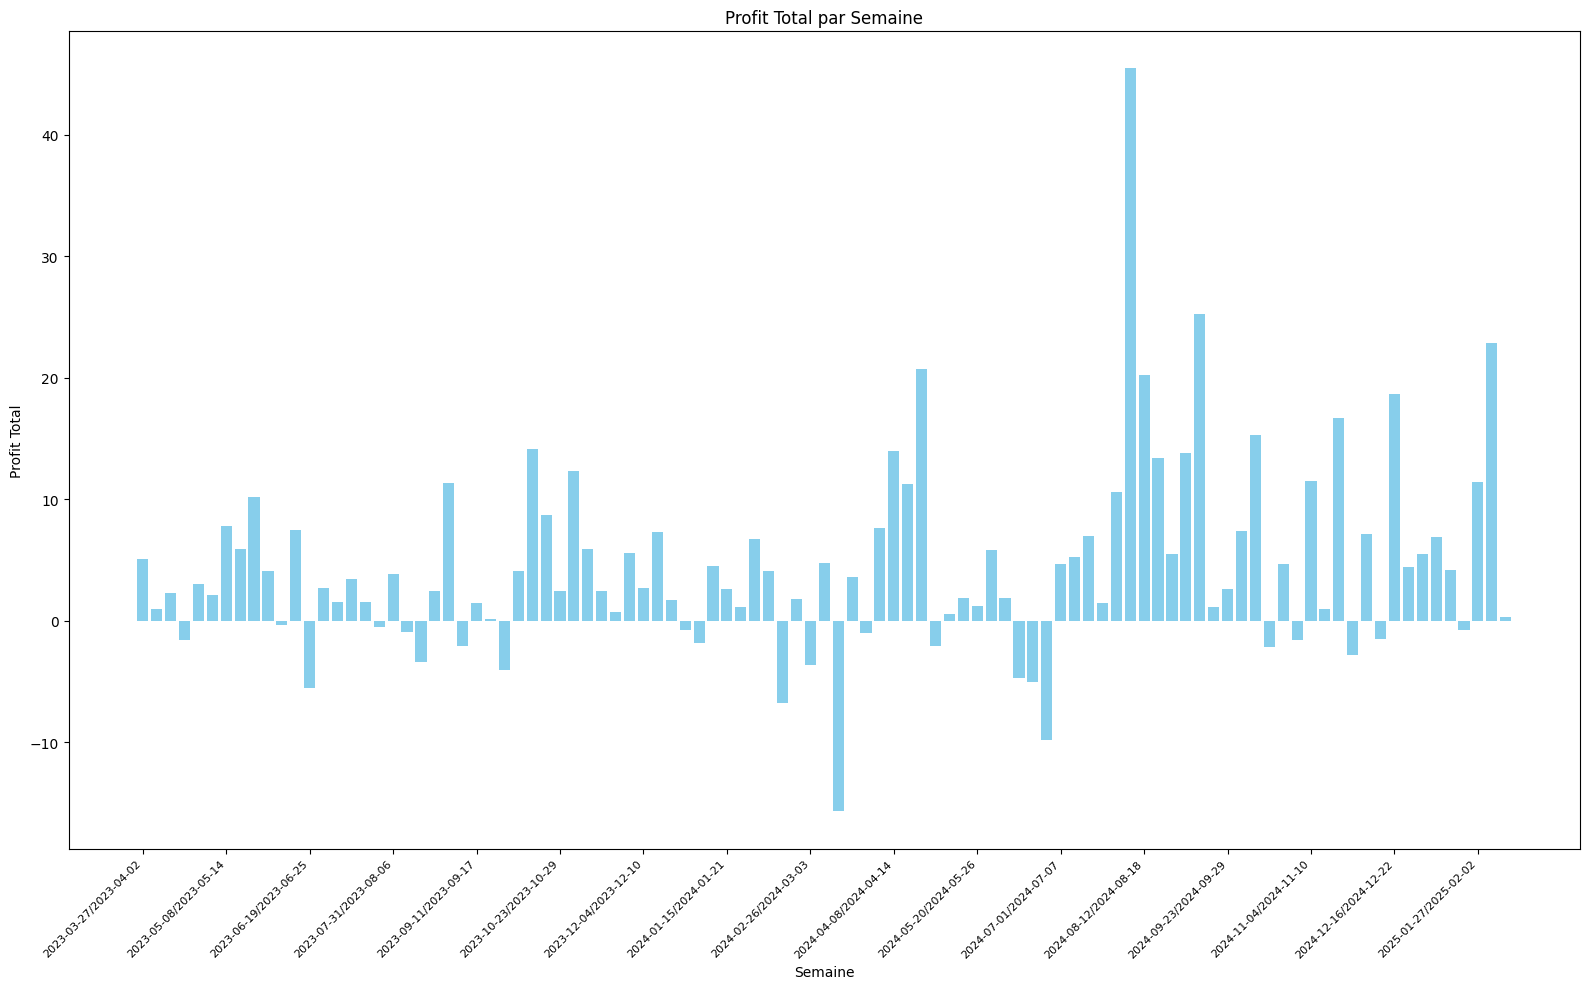

In [9]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 3)

In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70], [15, 40], [25, 50], [40, 50]]_tpInTicks=[[25, 70], [30, 80]]_"\
        "KijunExitMethod=[1, 3]_forbiddenHours=[[]]_slModifiers=[[[0.6, 0.15]], [[0.7, 0.2], [0.5, 0.12]], []]"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated.tail(10)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
38,88.709,228.60,199.50,0.154,-1.036,0.13,"(9090, 1157, 0)",5.4,41.3,"(40, 25, 50, 70)",0 days 00:06:00,0 days 00:16:00,[1],1,"[[0.6, 0.15]]",[],3,False,0
2,90.518,256.40,229.65,0.164,-1.305,0.11,"(8525, 893, 0)",5.5,52.1,"(50, 25, 70, 70)",0 days 00:06:10,0 days 00:17:30,[1],1,"[[0.6, 0.15]]",[],3,False,0
51,91.003,276.40,239.97,0.149,-1.302,0.10,"(11673, 1154, 0)",5.2,52.0,"(50, 25, 70, 70)",0 days 00:05:30,0 days 00:15:40,[1],2,"[[0.7, 0.2], [0.5, 0.12]]",[],1,False,0
55,91.012,277.82,243.35,0.151,-1.300,0.10,"(11048, 1091, 1)",5.1,51.9,"(50, 30, 70, 80)",0 days 00:05:20,0 days 00:15:12.500000,[1],2,"[[0.6, 0.15]]",[],1,False,0
37,89.121,281.70,251.50,0.153,-1.037,0.13,"(9478, 1157, 0)",5.3,41.4,"(40, 25, 50, 70)",0 days 00:05:50,0 days 00:15:10,[1],1,"[[0.6, 0.15]]",[],1,False,0
86,88.975,295.30,255.50,0.149,-1.037,0.12,"(12468, 1545, 1)",5.2,41.4,"(40, 25, 50, 70)",0 days 00:05:20,0 days 00:15:00,[1],2,"[[0.6, 0.15]]",[],3,False,0
1,90.837,317.12,289.26,0.164,-1.307,0.10,"(8912, 899, 0)",5.3,52.2,"(50, 25, 70, 70)",0 days 00:06:00,0 days 00:16:20,[1],1,"[[0.6, 0.15]]",[],1,False,0
85,89.009,337.05,296.63,0.151,-1.035,0.12,"(12666, 1564, 1)",5.1,41.3,"(40, 25, 50, 70)",0 days 00:05:20,0 days 00:14:30,[1],2,"[[0.6, 0.15]]",[],1,False,0
50,91.025,386.10,350.31,0.159,-1.303,0.10,"(11470, 1131, 0)",5.2,52.0,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:16:10,[1],2,"[[0.6, 0.15]]",[],3,False,0
49,91.112,454.55,417.97,0.163,-1.302,0.10,"(11737, 1145, 0)",5.2,52.0,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:15:30,[1],2,"[[0.6, 0.15]]",[],1,False,0


In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70], [40, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_"\
    "slModifiers=[[[0.6, 0.15]], [[0.5, 0.12], [0.7, 0.2]], []]_xRatio=[0, 8]"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,xRatio,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
12,47.567,-166.58,-302.26,0.067,-0.043,0.96,"(15817, 17435, 14524)",2.8,2.9,"(40, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,[],[],8,1,False,0
9,47.586,-165.02,-300.69,0.067,-0.043,0.96,"(15821, 17426, 14524)",2.8,2.9,"(50, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,[],[],8,1,False,0
10,47.629,-88.85,-224.56,0.072,-0.043,0.95,"(15842, 17419, 14525)",2.8,2.9,"(40, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.6, 0.15]]",[],8,1,False,0
7,47.650,-62.08,-197.78,0.073,-0.042,0.95,"(15847, 17410, 14525)",2.8,2.9,"(50, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.6, 0.15]]",[],8,1,False,0
11,47.717,40.02,-95.74,0.079,-0.042,0.94,"(15883, 17403, 14517)",2.7,2.9,"(40, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],8,1,False,0
6,89.138,-9.78,-49.23,0.128,-1.081,0.12,"(12384, 1509, 0)",5.2,43.1,"(40, 25, 70, 70)",0 days 00:05:30,0 days 00:15:00,[1],2,[],[],0,1,False,0
8,47.736,102.15,-33.60,0.083,-0.042,0.94,"(15888, 17395, 14517)",2.7,2.9,"(50, 25, 70, 70)",0 days 00:00:20,0 days 00:00:30,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],8,1,False,0
3,90.881,23.47,-12.81,0.130,-1.302,0.10,"(11611, 1165, 0)",5.3,52.0,"(50, 25, 70, 70)",0 days 00:05:30,0 days 00:15:50,[1],2,[],[],0,1,False,0
4,89.373,332.78,293.01,0.152,-1.081,0.12,"(12514, 1488, 0)",5.1,43.1,"(40, 25, 70, 70)",0 days 00:05:20,0 days 00:14:40,[1],2,"[[0.6, 0.15]]",[],0,1,False,0
1,91.112,458.35,421.77,0.163,-1.302,0.10,"(11737, 1145, 0)",5.2,52.0,"(50, 25, 70, 70)",0 days 00:05:20,0 days 00:15:30,[1],2,"[[0.6, 0.15]]",[],0,1,False,0


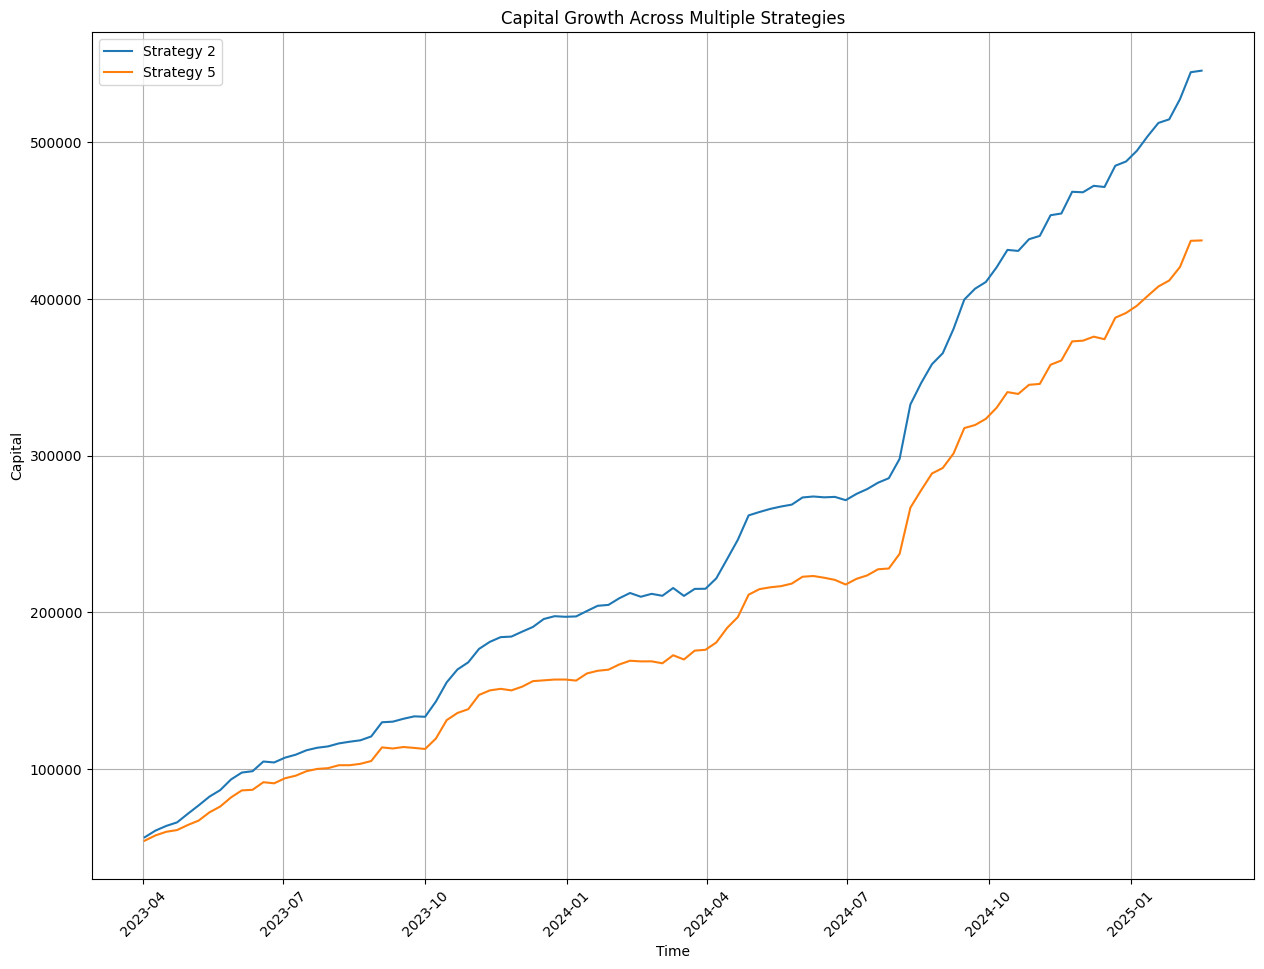

In [2]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[2,5],
                             plotSize=(15,11))

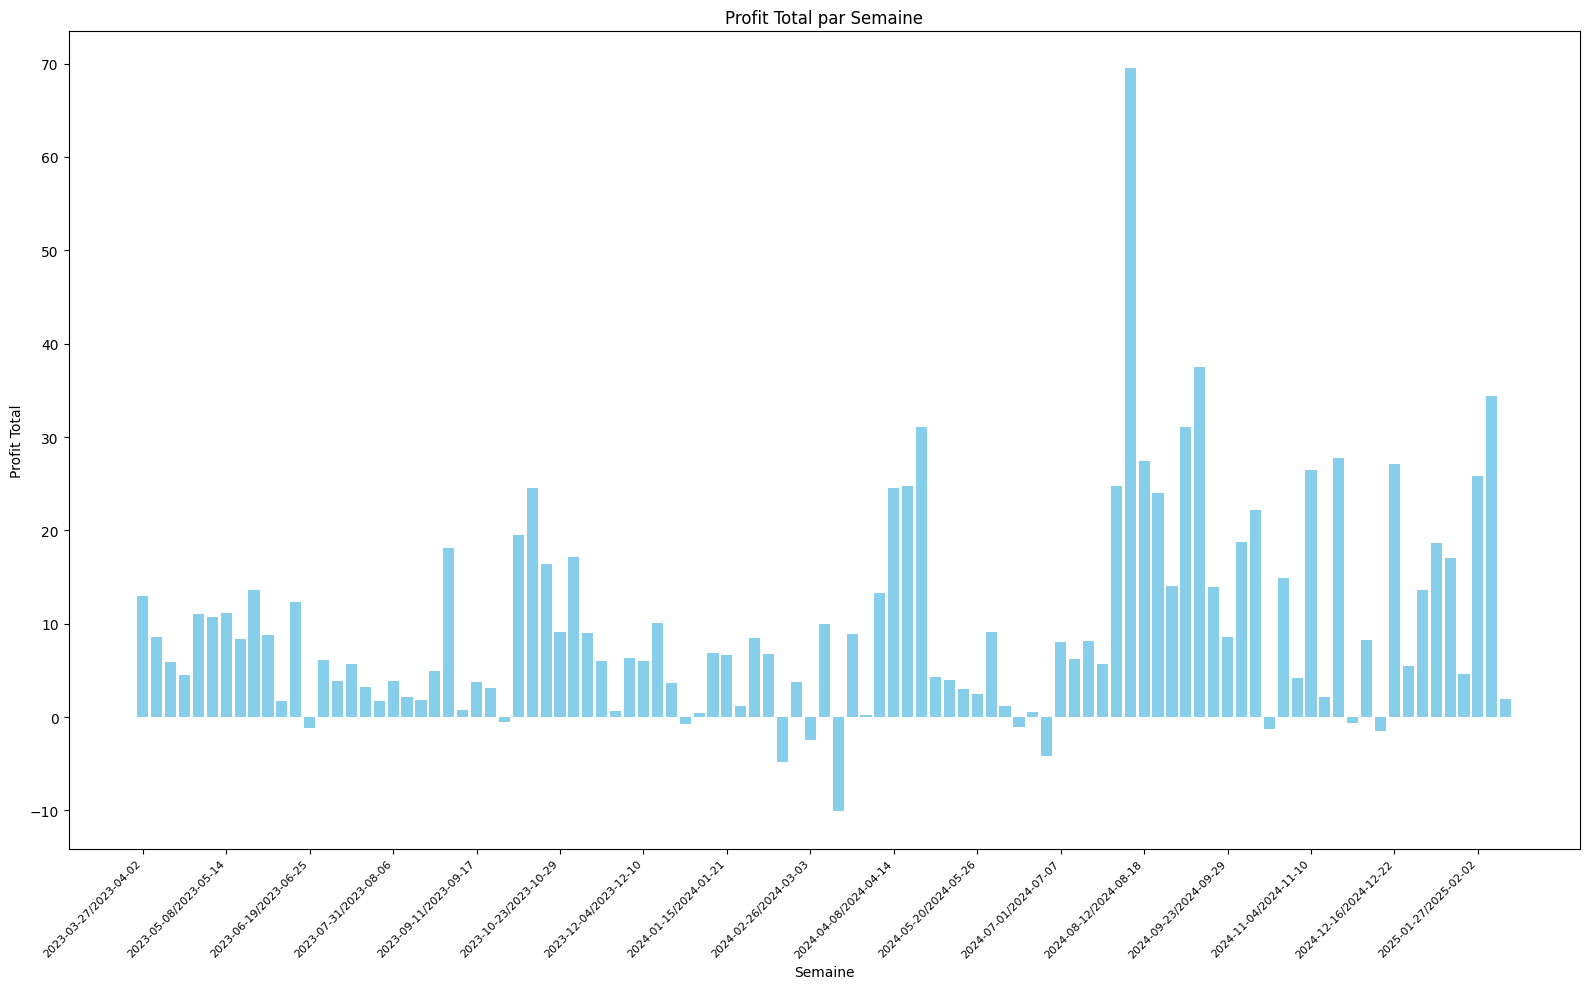

In [3]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 2)

In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_usCalendar"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,calendar_event,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
6,91.366,968.02,931.35,0.202,-1.302,0.1,"(11799, 1115, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],Unemployment,1,False,0
7,91.317,974.08,937.31,0.203,-1.303,0.1,"(11821, 1124, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],PMI,1,False,0
8,91.326,979.10,942.30,0.203,-1.302,0.1,"(11835, 1124, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],Employment,1,False,0
1,91.337,988.30,951.42,0.204,-1.302,0.1,"(11862, 1125, 0)",5.0,52.0,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],CPI,1,False,0
2,91.323,989.68,952.79,0.204,-1.302,0.1,"(11862, 1127, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],PPI,1,False,0
5,91.338,992.08,955.16,0.204,-1.302,0.1,"(11874, 1126, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],PCE,1,False,0
4,91.348,993.02,956.16,0.204,-1.300,0.1,"(11856, 1123, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:00,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],FOMC,1,False,0
3,91.346,994.30,957.45,0.204,-1.300,0.1,"(11853, 1123, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],Fed,1,False,0


91.328	991.68	954.73	0.204	-1.301	0.10	(11880, 1128, 0)

In [1]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[1]]_slInTicks=[[50, 70]]_tpInTicks=[[25, 70]]_KijunExitMethod=[1]_slModifiers=[[[0.5, 0.12], [0.7, 0.2]]]_usCalendar"

filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2) #start_date="2025-01-01 00:00:00", end_date="2025-02-14 12:00:00")
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],"[SL1, TP1] / [SL2, TP2] [Ticks]",Q2 duration (médiane),Q3 duration (75%),timeframes,tenkanCond,slModifiers,forbbiden Hours,calendar_event,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
1,91.358,986.78,950.10,0.204,-1.301,0.1,"(11798, 1116, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],"[CPI, PPI, Fed, FOMC, PCE]",1,False,0
2,91.354,992.15,955.36,0.204,-1.301,0.1,"(11834, 1120, 0)",5.0,51.9,"(50, 25, 70, 70)",0 days 00:05:10,0 days 00:15:10,[1],2,"[[0.5, 0.12], [0.7, 0.2]]",[],"[Fed, FOMC, PCE]",1,False,0


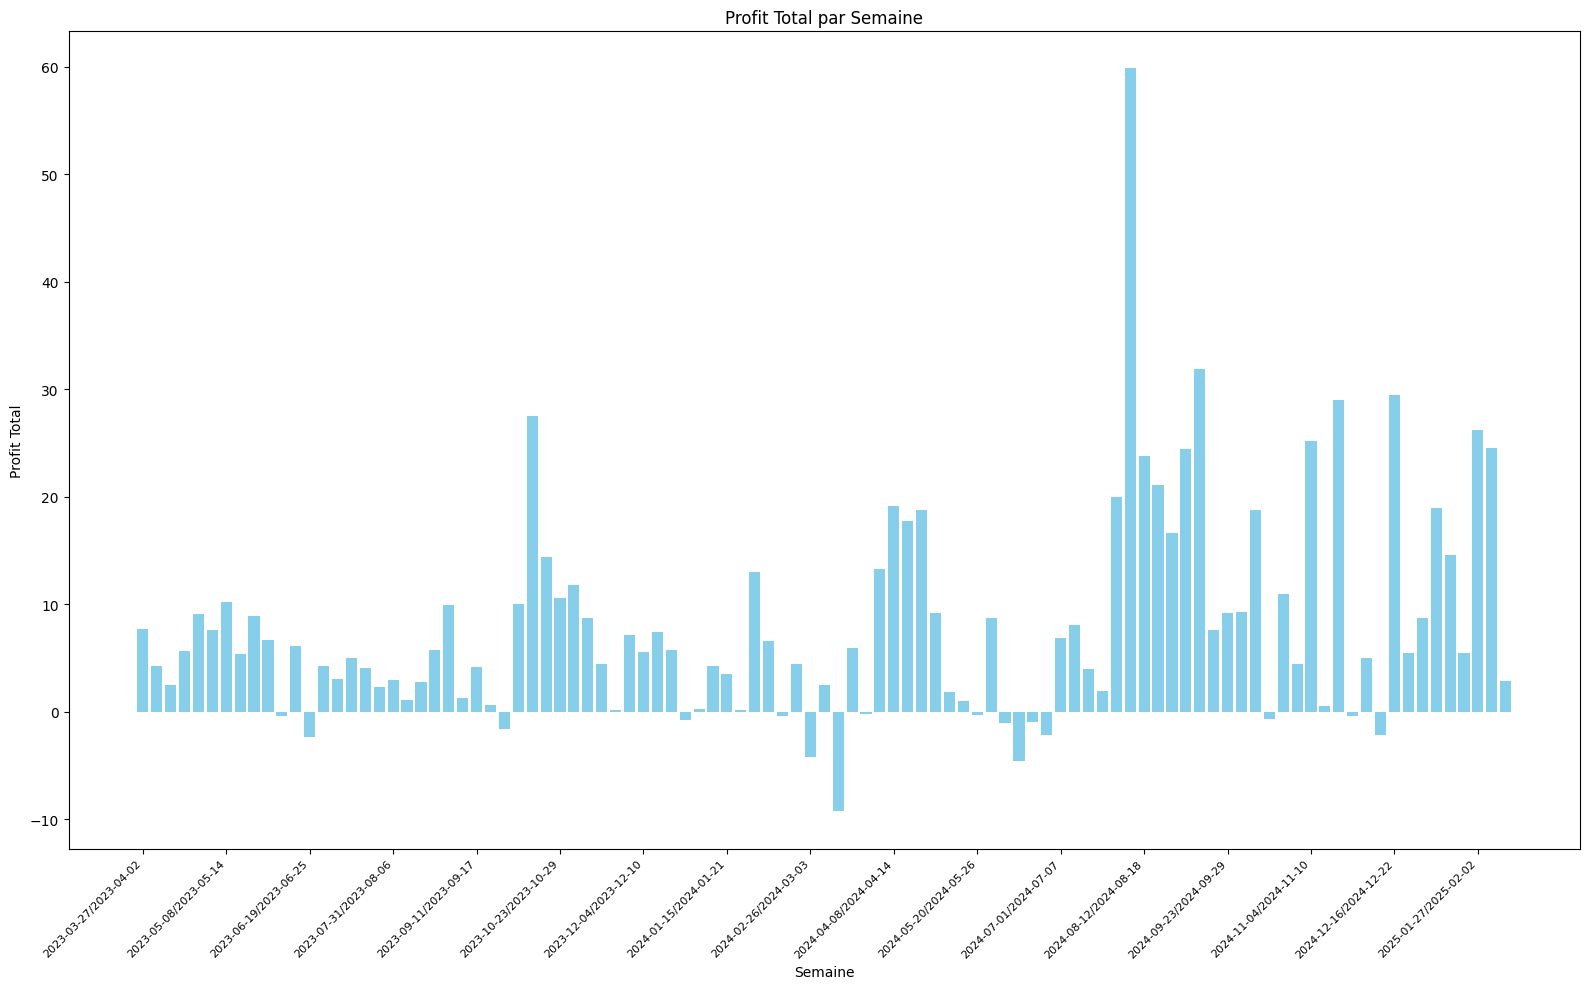

In [3]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(filepath, 1)

Nouvelles choses à tester : 
- condition de sorties supp. si on a un grand doji/marteau/pendu (***) => fait! : résultats mauvais
- rajouter la possibilité de déplacer le TP si le profit continu. Peut etre avec la tenkan ou avec un autre indicateur? l'ATR?
- rajouter une condition sur la taille de la bougie d'entrée = pas de trade si trop grande (**)
- tester d'augmenter la plage horraire de trading <7h ou >20h (**)
- analyser les heures les moins rentables = forbideenHours (**) 
- raffiner les niveaux de slModifiers/sl/tp (*)
- rajouter les niveaux du plus bas/plus haut journalier aux conditions d'entré (*)

choses à faire pour continuer à backtest : (déjà fait)
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 
- condition sur l'entré en position avec le RSI : entrer seulement si dans la zone de hausse ou de baisse temperé 
- condition sur la taille de la bougie (bougie trop grande = news). On pourra utiliser les taille moyenne de bougie/H
- utilise l'API pour avoir l'historique des news